In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import os 
import json
import sys

from functools import lru_cache

from botocore.exceptions import ClientError

In [3]:
# Tells the location of folders (e.g. aws folder) - creates a path
from user_path import set_up_path 

PATH = set_up_path()
sys.path.append(PATH['tools'])
sys.path.append(PATH['tools'] + '/functions')


In [4]:
# Importing custom libraries to connect to DWS and GSheet
from functions.database import get_data_from_warehouse
from utils.gspread.gsheet_data import GetSheetData

In [40]:
# Just checking if connected
query = """select COUNT(DISTINCT stuart_package_id)
    
from dim.package p
WHERE pu_city = 'London'
LIMIT 10
"""
data = get_data_from_warehouse(query)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [ ]:
data

# Catchment areas (CAs) and Pools

In [5]:
from password_downloader import get_passwords
# Gets a bunch of passwords. Here is specifically for the uk
PASSWORDS = get_passwords('uk') 

# PASSWORDS helps to get a connection to GSheet???
sheet = GetSheetData(DICT=PASSWORDS['gsheet_client_secret'])

In [6]:
# Connecting to GSheet
sheet_name = 'Sourcing / Onboarding Catchment Areas'

# Indicates which GSheet workbook I need
tab = 'OB Revamp Mapping'
catch_areas = sheet.worksheet_data(sheet_name, tab)

In [76]:
catch_areas.head()

,City,Sourcing / OB Catchment Areas,StuartPoolswithinCatchmentArea,,,,,,,,
0,Basildon,Basildon,BasildonCentral,Laindon,Pitsea,,,,,,
1,Birmingham,Birmingham Central,BirminghamCentral,BirminghamYardley,BirminghamHandsworth,,,,,,
2,Birmingham,Birmingham North,BirminghamErdington,BirminghamSuttonColdfield,,,,,,,
3,Birmingham,Birmingham East,BirminghamSolihull,BirminghamHallGreen,BirminghamAcocksGreen,,,,,,
4,Birmingham,Birmingham South,BirminghamSellyOak,Northfield,,,,,,,


In [8]:
# Pivot Longer the table
catch_areas1 = catch_areas.melt(id_vars=['City','Sourcing / OB Catchment Areas'])

In [9]:
# Dropping off City and Variable 
catch_areas1.drop(columns=['variable','City'], inplace=True) 

In [10]:
catch_areas1

,Sourcing / OB Catchment Areas,value
0,Basildon,BasildonCentral
1,Birmingham Central,BirminghamCentral
2,Birmingham North,BirminghamErdington
3,Birmingham East,BirminghamSolihull
4,Birmingham South,BirminghamSellyOak
...,...,...
733,Sunderland,
734,Teesside,
735,St Helens,
736,Warrington City,


In [11]:
# Replacing empty rows with na values and dropping them
catch_areas2 = catch_areas1.replace(r'^\s*$', np.nan, regex=True).dropna(subset=['value'])

In [12]:
catch_areas2

,Sourcing / OB Catchment Areas,value
0,Basildon,BasildonCentral
1,Birmingham Central,BirminghamCentral
2,Birmingham North,BirminghamErdington
3,Birmingham East,BirminghamSolihull
4,Birmingham South,BirminghamSellyOak
...,...,...
637,Newcastle,NewcastleRisingSun
695,London Outer E,Erith
700,London Border W,Twickenham
707,London Outer N,FinsburyPark


In [13]:
# Renaming columns
catch_areas2.rename(columns={'Sourcing / OB Catchment Areas':'catchment_area',
                            'value':'stuart_delivery_area'}, inplace=True)

In [14]:
catch_areas2

,catchment_area,stuart_delivery_area
0,Basildon,BasildonCentral
1,Birmingham Central,BirminghamCentral
2,Birmingham North,BirminghamErdington
3,Birmingham East,BirminghamSolihull
4,Birmingham South,BirminghamSellyOak
...,...,...
637,Newcastle,NewcastleRisingSun
695,London Outer E,Erith
700,London Border W,Twickenham
707,London Outer N,FinsburyPark


## PC Mapping

In [15]:
# CA and pool onboarded drivers worked in 
query = """


SELECT d.stuart_driver_id,
  --     d.applicant_fountain_id,
       uam.application_fountain_id,
       uam.postcode_found as driver_postCode,
       uam.application_pool,
       a.area_name_uscore,
   --    a.area_name_cap,
       a.area_name_clean,
       a.catchment_area,
       uam.lat as lat_driver, ---- Just in case
       uam.long as long_driver---- Just in case
 --      z.zone_name

FROM o

INNER JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = d.applicant_fountain_id

LEFT JOIN ops.area a
    ON uam.application_pool = a.area_name_uscore

WHERE d.zone_id = 2
AND d.is_active = TRUE

"""
courier_mapping = get_data_from_warehouse(query)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [16]:
courier_mapping

,stuart_driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,lat_driver,long_driver
0,342534,6ad7fba2-dbab-4dcc-bcd5-d6bf4cb6f35b,W3 7PQ,Acton,Acton,Acton,London Inner Lower NW,51.518375,-0.252240
1,363113,c5a86b3a-9793-4d0e-b0d5-262f7c4c9b0a,SE17 3QF,Kennington,Kennington,Kennington,London Inner E,51.487968,-0.101614
2,346884,89462909-4473-4d13-89c4-d4331e222529,N15 3PX,Wood_Green,Wood_Green,Wood Green,London Outer N,51.586530,-0.095057
3,346537,1b023183-a8bb-4fa0-b8f7-5f2edfd34421,TW5 9SD,Cranford,Cranford,Cranford,London Outer Lower NW,51.479192,-0.413286
4,345808,359b26bf-acf6-4da5-b8b5-5a7cb3f99f6b,N7 9QD,Camden,Camden,Camden,London Inner N,51.546373,-0.126110
...,...,...,...,...,...,...,...,...,...
9506,466153,31ff5644-a4cd-43f1-b169-48cafd60e2c6,E11 3ES,Leyton,Leyton,Leyton,London Outer NE,51.560615,0.014000
9507,469604,afbfed9c-2a79-489c-81c0-14b7877b46a5,SE9 5DW,Eltham,Eltham,Eltham,London Outer E,51.450411,0.058959
9508,455302,55318247-d6aa-4ce0-b45e-825d1c3f33ad,E13 8ES,Canning_Town,Canning_Town,Canning Town,London Outer NE,51.520636,0.017021
9509,477312,168d49fc-f022-4cd4-934a-1448b7d47798,DA17 6JP,Thamesmead,Thamesmead,Thamesmead,London Outer E,51.492592,0.150435


In [17]:
courier_mapping.describe()

,stuart_driver_id,lat_driver,long_driver
count,9511.000000,9450.000000,9450.000000
mean,418922.626433,51.534036,-0.166695
std,43542.664967,0.293966,0.411841
min,339072.000000,50.339817,-4.978623
25%,385963.000000,51.448604,-0.252215
50%,410763.000000,51.522007,-0.107106
75%,462710.500000,51.567456,-0.010001
max,485805.000000,56.127844,1.122188


In [18]:
courier_mapping.isnull().sum()

stuart_driver_id             0
application_fountain_id      0
driver_postcode              0
application_pool             0
area_name_uscore           942
area_name_clean            942
catchment_area             942
lat_driver                  61
long_driver                 61
dtype: int64

In [19]:
# Percentage of couriers not living in CA
not_in_CA = courier_mapping['catchment_area'].isnull().sum() * 100 / len(courier_mapping.catchment_area)
print(not_in_CA)

9.904321312164862


In [20]:
# Percentage of couriers living in CA
in_CA = courier_mapping['catchment_area'].notnull().sum() * 100 / len(courier_mapping.catchment_area)
print(in_CA)

90.09567868783513


In [21]:
courier_inCA = courier_mapping

In [49]:
courier_mapping['in_CA']= np.where(courier_mapping['catchment_area'].notnull() , 'Yes' , 'No')
courier_mapping

,stuart_driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,lat_driver,long_driver,in_CA
0,342534,6ad7fba2-dbab-4dcc-bcd5-d6bf4cb6f35b,W3 7PQ,Acton,Acton,Acton,London Inner Lower NW,51.518375,-0.252240,Yes
1,363113,c5a86b3a-9793-4d0e-b0d5-262f7c4c9b0a,SE17 3QF,Kennington,Kennington,Kennington,London Inner E,51.487968,-0.101614,Yes
2,346884,89462909-4473-4d13-89c4-d4331e222529,N15 3PX,Wood_Green,Wood_Green,Wood Green,London Outer N,51.586530,-0.095057,Yes
3,346537,1b023183-a8bb-4fa0-b8f7-5f2edfd34421,TW5 9SD,Cranford,Cranford,Cranford,London Outer Lower NW,51.479192,-0.413286,Yes
4,345808,359b26bf-acf6-4da5-b8b5-5a7cb3f99f6b,N7 9QD,Camden,Camden,Camden,London Inner N,51.546373,-0.126110,Yes
...,...,...,...,...,...,...,...,...,...,...
9506,466153,31ff5644-a4cd-43f1-b169-48cafd60e2c6,E11 3ES,Leyton,Leyton,Leyton,London Outer NE,51.560615,0.014000,Yes
9507,469604,afbfed9c-2a79-489c-81c0-14b7877b46a5,SE9 5DW,Eltham,Eltham,Eltham,London Outer E,51.450411,0.058959,Yes
9508,455302,55318247-d6aa-4ce0-b45e-825d1c3f33ad,E13 8ES,Canning_Town,Canning_Town,Canning Town,London Outer NE,51.520636,0.017021,Yes
9509,477312,168d49fc-f022-4cd4-934a-1448b7d47798,DA17 6JP,Thamesmead,Thamesmead,Thamesmead,London Outer E,51.492592,0.150435,Yes


In [50]:
in_CA = courier_mapping.groupby('in_CA').agg({'stuart_driver_id':'count'}).reset_index()
in_CA

,in_CA,stuart_driver_id
0,No,942
1,Yes,8569


In [72]:
# Percentage of drivers who live within CA
in_CA['Percentage_drivers_inCA'] = (in_CA['stuart_driver_id']/in_CA['stuart_driver_id'].sum()) * 100
in_CA = in_CA.round(0)

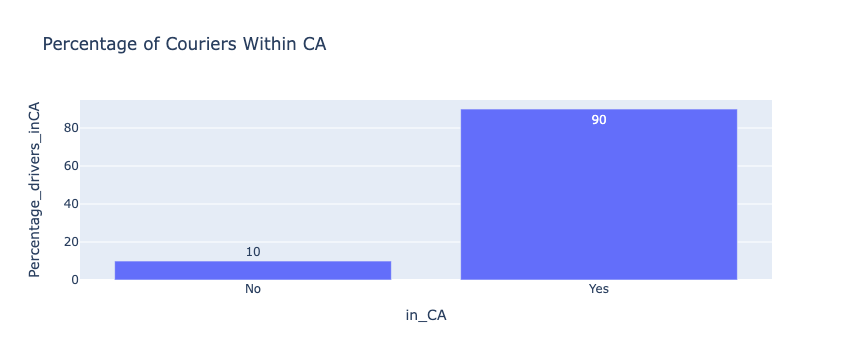

In [83]:
fig1 = px.bar(in_CA, x = 'in_CA' , y = 'Percentage_drivers_inCA', title= 'Percentage of Couriers Within CA', text = 'Percentage_drivers_inCA')
fig1.show()

In [60]:
# Top 5 CA with highest number of resident couriers
top_5_CA = courier_mapping.groupby('catchment_area').agg({'stuart_driver_id':'count'}).reset_index()
top_5_CA.head(5)

,catchment_area,stuart_driver_id
0,Altrincham,1
1,Basildon,2
2,Birmingham Central,2
3,Birmingham East,1
4,Bolton,2


In [63]:
# Sorting values in descending order
top_5_CA = top_5_CA.sort_values(by='stuart_driver_id', ascending=False)
top_5_CA.head(5)

,catchment_area,stuart_driver_id
36,London Outer NE,961
35,London Outer N,844
40,London Outer Upper NW,793
30,London Inner S,715
37,London Outer S,602


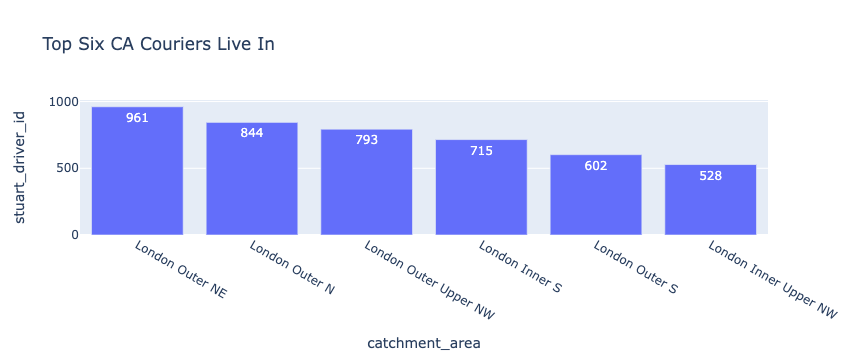

In [84]:
fig2 = px.bar(top_5_CA.head(6), x = 'catchment_area' , y = 'stuart_driver_id', title = 'Top Six CA Couriers Live In' , text = 'stuart_driver_id')
fig2.show()

## Delivery Database 

            Creating a metric to get "CA each driver mostly worked in"

In [103]:
query_2 = '''

SELECT -------------------- Package
       cd.driver_id,          -- stuart_driver_id
       z.zone_name,
       cd.zone_id,
       a.catchment_area as pu_CA,

    ------------------  Driver
       uam.postcode_found as driver_postCode,
       ad.catchment_area as driver_CA,
       count( distinct p.package_id) as no_packages

FROM modeled_core.driver cd

INNER JOIN modeled_core.zones z
USING (zone_id)

LEFT JOIN modeled_core.delivery d
    ON cd.driver_id = d.driver_id

LEFT JOIN modeled_core.package p
    ON d.package_id = p.package_id

LEFT JOIN modeled_core.location l
    ON p.pu_location_id = l.location_id

LEFT JOIN ops.area a
    ON REPLACE(l.delivery_area_name , '_' , '') = a.area_name_cap -- pool area for packages

LEFT JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = cd.applicant_fountain_id

LEFT JOIN ops.area ad
    ON uam.application_pool = ad.area_name_uscore   -- pool area for driver ca

WHERE z.country_id = 2
AND DATE(p.time_window_pu_start_utc) >= '2021-07-01'

GROUP BY 1, 2, 3, 4, 5, 6

'''

deliveries = get_data_from_warehouse(query_2)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [104]:
# Getting multiple rows per driver as they can work in different catchment areas
# Got 83,641 when had LEFT JOIN for application_fountain_id
deliveries.shape

(97827, 7)

In [105]:
# dropping duplicates (no duplicates)
no_dup_deliveries = deliveries.drop_duplicates()
no_dup_deliveries.shape

# No duplicates

(97827, 7)

In [106]:
no_dup_deliveries['driver_id'].nunique()

37973

In [107]:
# Generating a csv file with drivers and their deliveries
no_dup_deliveries.to_csv('data/deliveries_and_catchement_areas.csv' , index = False )

# Another way deliveries.to_csv('deliveries.csv') 

In [154]:
# Dropped all None values in driver_ca: Removing drivers who don't live in CA
no_dup_deliveries = no_dup_deliveries[no_dup_deliveries['driver_ca'].isnull()==False]

In [155]:
no_dup_deliveries['driver_id'].nunique()

12333

In [171]:
no_dup_deliveries.head(10)

,driver_id,zone_name,zone_id,pu_ca,driver_postcode,driver_ca,no_packages
2,373615,Darlington,13,Darlington,TS4 2RR,Teesside,166
4,431872,London,2,London Outer N,N18 2PP,London Outer N,3059
5,457432,Birmingham,53,Wolverhampton,B20 3ND,Birmingham Central,522
7,431931,London,2,London Outer N,EN4 8TF,London Outer N,1413
11,385574,Darlington,13,Teesside,TS18 3AN,Teesside,2355
14,416323,London,2,London Outer S,CR0 2US,London Outer S,1230
17,362062,Reading,47,Reading,RG1 3NA,Reading,1228
20,398305,Blackpool,56,Blackpool South,FY1 5EG,Blackpool South,3738
25,382857,London,2,London Outer NE,E10 5DG,London Outer NE,1976
29,382371,London,2,London Border N,N9 9ER,London Border N,2689


In [146]:
no_dup_deliveries.groupby(['driver_id'])\
.agg({'zone_name' : 'nunique'})\
.sort_values('zone_name', ascending = False)\
.head(597)  # which is 600/12,000 = around 5%
                                             

,zone_name
driver_id,
412933,4
415506,4
350887,4
399519,4
448056,3
...,...
462373,2
346970,2
347429,2


In [174]:
zone_test = no_dup_deliveries.groupby(['driver_id'])\
.agg({'zone_name' : 'nunique' , 'no_packages' : 'max'})\
.sort_values('zone_name', ascending = False)\
.reset_index()

In [176]:
zone_test = zone_test[zone_test['zone_name']> 1].copy()

In [177]:
zone_test.sum()  # wrong!

driver_id      246354729
zone_name           1221
no_packages       375744
dtype: int64

In [178]:
no_dup_deliveries.sum()

/var/folders/07/_0xz2ftj6wgfn6ghm9_npgg40000gp/T/ipykernel_32796/1650789499.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  no_dup_deliveries.sum()


driver_id                                                12537609039
zone_name          DarlingtonLondonBirminghamLondonDarlingtonLond...
zone_id                                                       415081
driver_postcode    TS4 2RRN18 2PPB20 3NDEN4 8TFTS18 3ANCR0 2USRG1...
driver_ca          TeessideLondon Outer NBirmingham CentralLondon...
no_packages                                                  7114729
dtype: object

In [156]:
# One driver could have done > 1 delivery and do deliveries in multiple CA
no_dup_deliveries.shape

(29901, 7)

In [157]:
no_dup_deliveries

,driver_id,zone_name,zone_id,pu_ca,driver_postcode,driver_ca,no_packages
2,373615,Darlington,13,Darlington,TS4 2RR,Teesside,166
4,431872,London,2,London Outer N,N18 2PP,London Outer N,3059
5,457432,Birmingham,53,Wolverhampton,B20 3ND,Birmingham Central,522
7,431931,London,2,London Outer N,EN4 8TF,London Outer N,1413
11,385574,Darlington,13,Teesside,TS18 3AN,Teesside,2355
...,...,...,...,...,...,...,...
97812,429153,London,2,London Border N,RM1 4NU,London Border NE,1
97815,347764,London,2,None,SW16 6AP,London Inner S,1
97816,367736,Liverpool,28,Liverpool East,CH41 2TW,Liverpool Wirral,1
97822,381081,London,2,London Border E,W9 3NQ,London Inner Upper NW,1


In [172]:
no_dup_deliveries[no_dup_deliveries['driver_id']==412933]

,driver_id,zone_name,zone_id,pu_ca,driver_postcode,driver_ca,no_packages
1571,412933,Plymouth,39,Plymstock,PL1 5AE,Plymouth,291
5388,412933,Nottingham,71,Plymstock,PL1 5AE,Plymouth,291
23833,412933,Leicester,69,Plymstock,PL1 5AE,Plymouth,291
31822,412933,Leicester,69,Plymouth,PL1 5AE,Plymouth,383
32082,412933,Milton Keynes,70,Plymouth,PL1 5AE,Plymouth,383
38492,412933,Leicester,69,Milton Keynes,PL1 5AE,Plymouth,70
47872,412933,Milton Keynes,70,Milton Keynes,PL1 5AE,Plymouth,70
59690,412933,Plymouth,39,Plymouth,PL1 5AE,Plymouth,383
59922,412933,Nottingham,71,Plymouth,PL1 5AE,Plymouth,383
60665,412933,Milton Keynes,70,Plymstock,PL1 5AE,Plymouth,291


In [158]:
# New column: total number of packages each driver did
new_df = no_dup_deliveries.groupby(['driver_id', 'driver_ca']).sum('no_packages').reset_index()

# Merging two datasets
mapped = pd.merge(no_dup_deliveries, new_df, left_on = ['driver_id','driver_ca']
                  , right_on = ['driver_id','driver_ca'])
mapped

,driver_id,zone_name,zone_id_x,pu_ca,driver_postcode,driver_ca,no_packages_x,zone_id_y,no_packages_y
0,373615,Darlington,13,Darlington,TS4 2RR,Teesside,166,13,166
1,431872,London,2,London Outer N,N18 2PP,London Outer N,3059,4,3083
2,431872,London,2,London Border N,N18 2PP,London Outer N,24,4,3083
3,457432,Birmingham,53,Wolverhampton,B20 3ND,Birmingham Central,522,106,553
4,457432,Birmingham,53,Walsall,B20 3ND,Birmingham Central,31,106,553
...,...,...,...,...,...,...,...,...,...
29896,430921,Blackpool,56,Blackpool South,FY4 4RW,Blackpool South,1,56,1
29897,424886,Sheffield,20,Rotherham,S60 3BW,Rotherham,1,20,1
29898,351333,London,2,London Inner S,SW18 1DE,London Inner S,1,2,1
29899,469101,Warrington,68,Warrington City,WA5 9PW,Warrington City,1,68,1


In [159]:
mapped['driver_id'].nunique()

12333

In [160]:
# Renaming columns
mapped = mapped.rename(columns = {'no_packages_x' : 'nb_packages_per_CA', 'no_packages_y' : 'total_nb_packages' , 'zone_name' : 'zone_name_of_driver_pu_ca'})
mapped

,driver_id,zone_name_of_driver_pu_ca,zone_id_x,pu_ca,driver_postcode,driver_ca,nb_packages_per_CA,zone_id_y,total_nb_packages
0,373615,Darlington,13,Darlington,TS4 2RR,Teesside,166,13,166
1,431872,London,2,London Outer N,N18 2PP,London Outer N,3059,4,3083
2,431872,London,2,London Border N,N18 2PP,London Outer N,24,4,3083
3,457432,Birmingham,53,Wolverhampton,B20 3ND,Birmingham Central,522,106,553
4,457432,Birmingham,53,Walsall,B20 3ND,Birmingham Central,31,106,553
...,...,...,...,...,...,...,...,...,...
29896,430921,Blackpool,56,Blackpool South,FY4 4RW,Blackpool South,1,56,1
29897,424886,Sheffield,20,Rotherham,S60 3BW,Rotherham,1,20,1
29898,351333,London,2,London Inner S,SW18 1DE,London Inner S,1,2,1
29899,469101,Warrington,68,Warrington City,WA5 9PW,Warrington City,1,68,1


In [161]:
# Reordering columns for readability
mapped = mapped[['driver_id', 'driver_postcode' , 'driver_ca' , 'pu_ca' , 'nb_packages_per_CA' , 'total_nb_packages' ,'zone_name_of_driver_pu_ca']].copy()
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca
0,373615,TS4 2RR,Teesside,Darlington,166,166,Darlington
1,431872,N18 2PP,London Outer N,London Outer N,3059,3083,London
2,431872,N18 2PP,London Outer N,London Border N,24,3083,London
3,457432,B20 3ND,Birmingham Central,Wolverhampton,522,553,Birmingham
4,457432,B20 3ND,Birmingham Central,Walsall,31,553,Birmingham
...,...,...,...,...,...,...,...
29896,430921,FY4 4RW,Blackpool South,Blackpool South,1,1,Blackpool
29897,424886,S60 3BW,Rotherham,Rotherham,1,1,Sheffield
29898,351333,SW18 1DE,London Inner S,London Inner S,1,1,London
29899,469101,WA5 9PW,Warrington City,Warrington City,1,1,Warrington


In [59]:
# Only deliveries that were in PU_CA
mapped_filter = mapped[mapped['driver_ca']== mapped['pu_ca']].copy()
mapped_filter

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington
3,406002,EN5 2HX,London Outer N,London Outer N,560,1801,London
6,427982,WS10 8PP,Walsall,Walsall,59,1949,Birmingham
8,396888,PL7 4AT,Plymouth,Plymouth,1965,2199,Plymouth
...,...,...,...,...,...,...,...
29733,385633,S2 5JF,Sheffield,Sheffield,1,1,Sheffield
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead


In [60]:
# Percentage of delivered packages for each driver living in CA
mapped_filter['percentage_of_packages_in_Dca'] = mapped_filter['nb_packages_per_CA'] / (mapped_filter['total_nb_packages']) * 100
mapped_filter

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca,percentage_of_packages_in_Dca
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside,50.000000
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington,50.000000
3,406002,EN5 2HX,London Outer N,London Outer N,560,1801,London,31.093837
6,427982,WS10 8PP,Walsall,Walsall,59,1949,Birmingham,3.027193
8,396888,PL7 4AT,Plymouth,Plymouth,1965,2199,Plymouth,89.358799
...,...,...,...,...,...,...,...,...
29733,385633,S2 5JF,Sheffield,Sheffield,1,1,Sheffield,100.000000
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby,100.000000
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London,100.000000
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead,100.000000


In [61]:
# Considering mostly_worked_in_ca when percentage of packages in driver CA is over 50
mapped_filter['mostly_worked_in_driver_ca'] = np.where(mapped_filter['percentage_of_packages_in_Dca'] > 50, 1, 0)
mapped_filter

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca,percentage_of_packages_in_Dca,mostly_worked_in_driver_ca
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside,50.000000,0
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington,50.000000,0
3,406002,EN5 2HX,London Outer N,London Outer N,560,1801,London,31.093837,0
6,427982,WS10 8PP,Walsall,Walsall,59,1949,Birmingham,3.027193,0
8,396888,PL7 4AT,Plymouth,Plymouth,1965,2199,Plymouth,89.358799,1
...,...,...,...,...,...,...,...,...,...
29733,385633,S2 5JF,Sheffield,Sheffield,1,1,Sheffield,100.000000,1
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby,100.000000,1
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London,100.000000,1
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead,100.000000,1


In [62]:
mapped_filter.describe()
# 85% of drivers who live in CA mostly do deliveries in their CA

,driver_id,nb_packages_per_CA,total_nb_packages,percentage_of_packages_in_Dca,mostly_worked_in_driver_ca
count,11202.000000,11202.000000,11202.000000,11202.000000,11202.000000
mean,425501.003839,417.496786,588.011516,78.245336,0.778611
std,39393.993843,632.339925,796.620078,32.987224,0.415200
min,339370.000000,1.000000,1.000000,0.026455,0.000000
25%,398282.750000,22.000000,49.000000,63.922343,1.000000
50%,425533.500000,131.000000,246.000000,98.164372,1.000000
75%,462328.750000,537.000000,847.000000,100.000000,1.000000
max,490791.000000,5532.000000,8480.000000,100.000000,1.000000


In [ ]:
# Metric 2: Create a column: mostly_worked_in_ca by choosing the CA where a courier did his most deliveries in. 
# Then compare if this CA is the same as driver ca as 1 or 0. 
# Then calculate the % of 1s 


# Most Deliveries Metric

In [114]:
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington
2,406002,EN5 2HX,London Outer N,London Border N,1240,1801,London
3,406002,EN5 2HX,London Outer N,London Outer N,560,1801,London
4,406002,EN5 2HX,London Outer N,None,1,1801,London
...,...,...,...,...,...,...,...
29734,484451,S65 1PD,Rotherham,Sheffield,1,1,Sheffield
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead


In [119]:
# New df is the same as mapped
new_metric = mapped.copy()
new_metric

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington
2,406002,EN5 2HX,London Outer N,London Border N,1240,1801,London
3,406002,EN5 2HX,London Outer N,London Outer N,560,1801,London
4,406002,EN5 2HX,London Outer N,None,1,1801,London
...,...,...,...,...,...,...,...
29734,484451,S65 1PD,Rotherham,Sheffield,1,1,Sheffield
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead


In [120]:
new_metric['max_ca_deliveries']= new_metric.groupby(['driver_id'])['nb_packages_per_CA'].transform(max)
new_metric


,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca,max_ca_deliveries
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside,2118
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington,2118
2,406002,EN5 2HX,London Outer N,London Border N,1240,1801,London,1240
3,406002,EN5 2HX,London Outer N,London Outer N,560,1801,London,1240
4,406002,EN5 2HX,London Outer N,None,1,1801,London,1240
...,...,...,...,...,...,...,...,...
29734,484451,S65 1PD,Rotherham,Sheffield,1,1,Sheffield,1
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby,1
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London,1
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead,1


In [121]:
new_metric.head(20)

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca,max_ca_deliveries
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside,2118
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington,2118
2,406002,EN5 2HX,London Outer N,London Border N,1240,1801,London,1240
3,406002,EN5 2HX,London Outer N,London Outer N,560,1801,London,1240
4,406002,EN5 2HX,London Outer N,None,1,1801,London,1240
5,427982,WS10 8PP,Walsall,Wolverhampton,1888,1949,Birmingham,1888
6,427982,WS10 8PP,Walsall,Walsall,59,1949,Birmingham,1888
7,427982,WS10 8PP,Walsall,Dudley & West Bromwich,2,1949,Birmingham,1888
8,396888,PL7 4AT,Plymouth,Plymouth,1965,2199,Plymouth,1965
9,396888,PL7 4AT,Plymouth,Plymstock,234,2199,Plymouth,1965


In [122]:
# Metric 2: Create a column: mostly_worked_in_ca by choosing the CA where a courier did his most deliveries in. 

new_metric2 = new_metric[new_metric['nb_packages_per_CA'] == new_metric['max_ca_deliveries']].copy()
new_metric2


,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca,max_ca_deliveries
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside,2118
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington,2118
2,406002,EN5 2HX,London Outer N,London Border N,1240,1801,London,1240
5,427982,WS10 8PP,Walsall,Wolverhampton,1888,1949,Birmingham,1888
8,396888,PL7 4AT,Plymouth,Plymouth,1965,2199,Plymouth,1965
...,...,...,...,...,...,...,...,...
29734,484451,S65 1PD,Rotherham,Sheffield,1,1,Sheffield,1
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby,1
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London,1
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead,1


In [123]:
# Then compare if this CA is the same as driver ca as 1 or 0. 
new_metric2['is_same'] = np.where(new_metric2['pu_ca'] == new_metric2['driver_ca'], 1, 0)
new_metric2

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,zone_name_of_driver_pu_ca,max_ca_deliveries,is_same
0,411141,TS1 4QD,Teesside,Teesside,2118,4236,Teesside,2118,1
1,411141,TS1 4QD,Teesside,Teesside,2118,4236,Darlington,2118,1
2,406002,EN5 2HX,London Outer N,London Border N,1240,1801,London,1240,0
5,427982,WS10 8PP,Walsall,Wolverhampton,1888,1949,Birmingham,1888,0
8,396888,PL7 4AT,Plymouth,Plymouth,1965,2199,Plymouth,1965,1
...,...,...,...,...,...,...,...,...,...
29734,484451,S65 1PD,Rotherham,Sheffield,1,1,Sheffield,1,0
29735,475822,DE24 8SG,Derby,Derby,1,1,Derby,1,1
29736,477225,SW17 9ES,London Inner S,London Inner S,1,1,London,1,1
29737,448077,NE8 4XJ,Gateshead,Gateshead,1,1,Newcastle-Gateshead,1,1


In [125]:
# Then calculate the % of 1s 
new_metric2.describe()

,driver_id,nb_packages_per_CA,total_nb_packages,max_ca_deliveries,is_same
count,13001.000000,13001.000000,13001.000000,13001.000000,13001.000000
mean,425525.566264,498.398892,613.457734,498.398892,0.717483
std,40085.053408,671.572779,881.158181,671.572779,0.450241
min,339370.000000,1.000000,1.000000,1.000000,0.000000
25%,397285.000000,39.000000,46.000000,39.000000,0.000000
50%,425790.000000,202.000000,242.000000,202.000000,1.000000
75%,462506.000000,716.000000,862.000000,716.000000,1.000000
max,490791.000000,5532.000000,12681.000000,5532.000000,1.000000
